In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 80

ng =7

ng_refs = (/ 7 /) 

nref =1

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

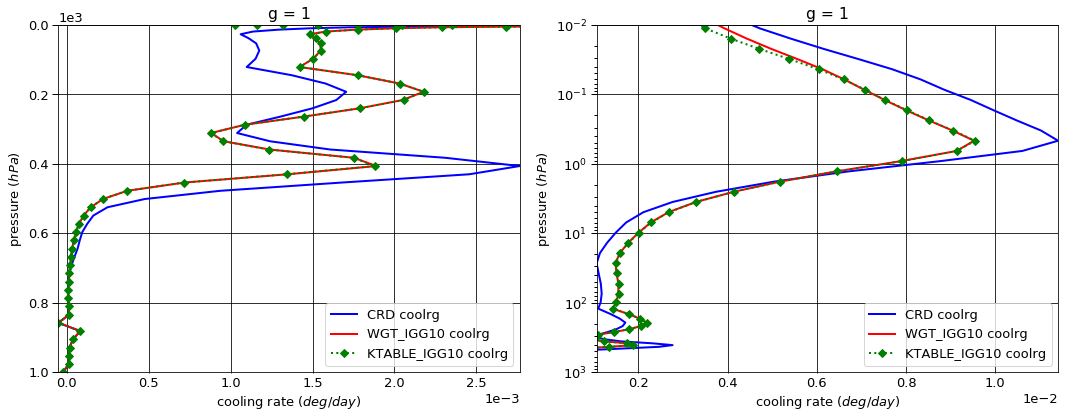

# Figure: cooling rate g-group 2

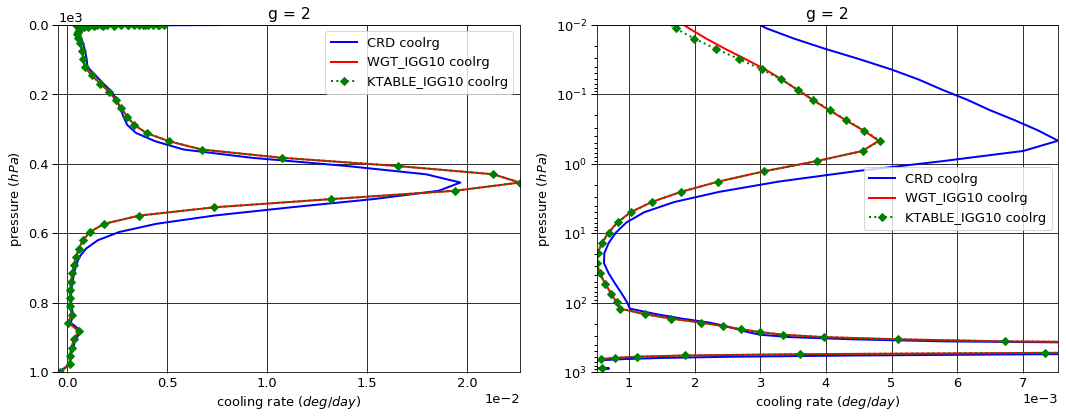

# Figure: cooling rate g-group 3

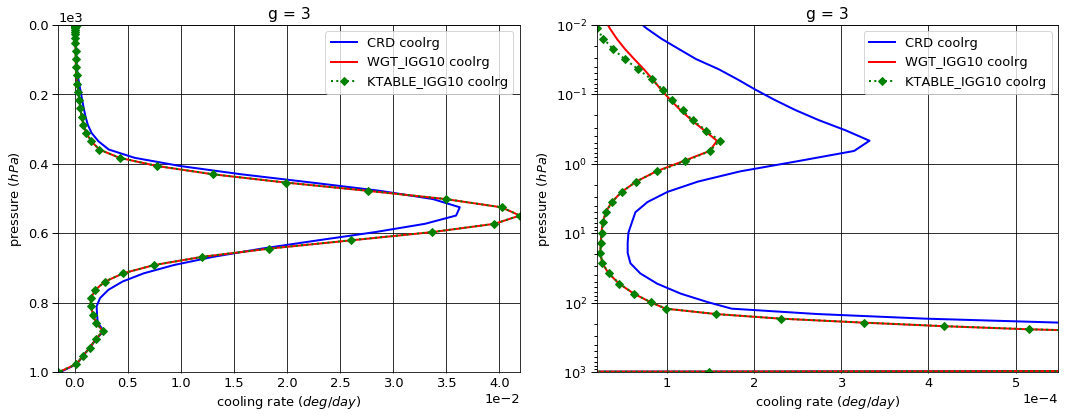

# Figure: cooling rate g-group 4

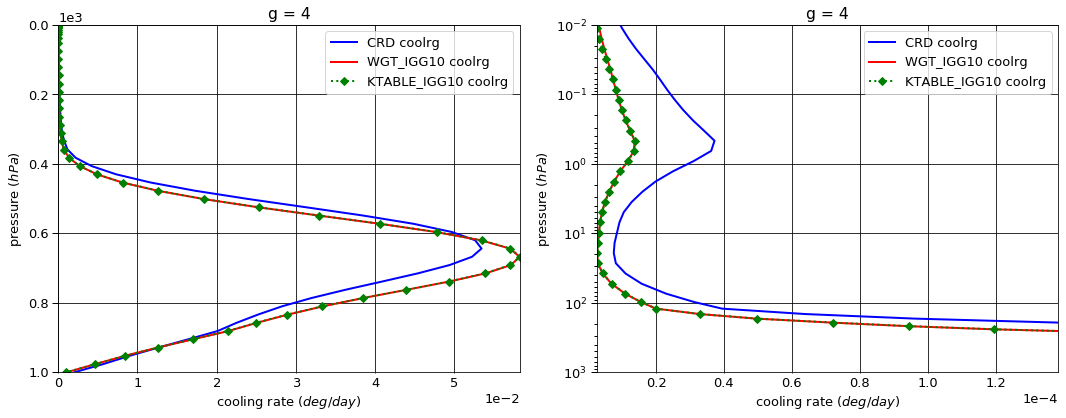

# Figure: cooling rate g-group 5

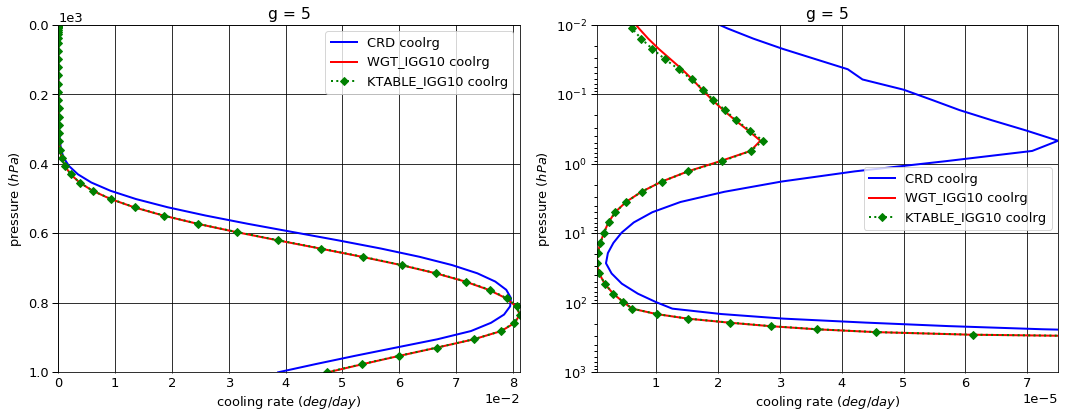

# Figure: cooling rate g-group 6

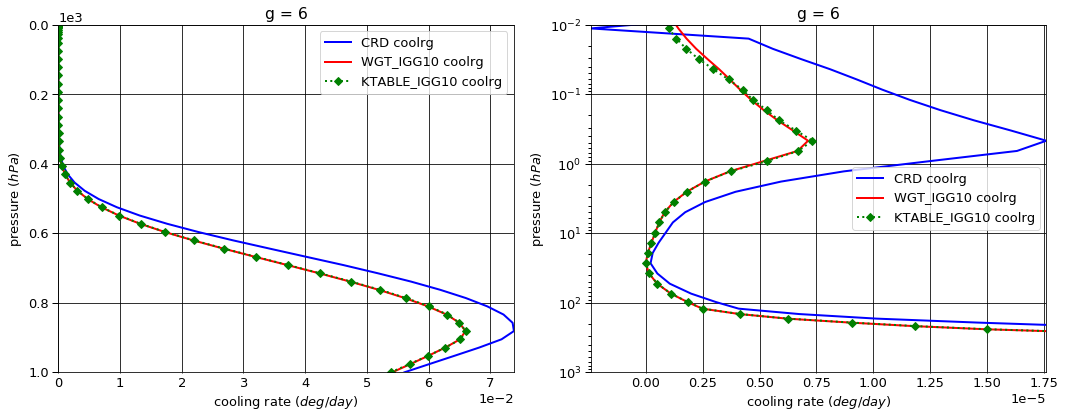

# Figure: cooling rate g-group 7

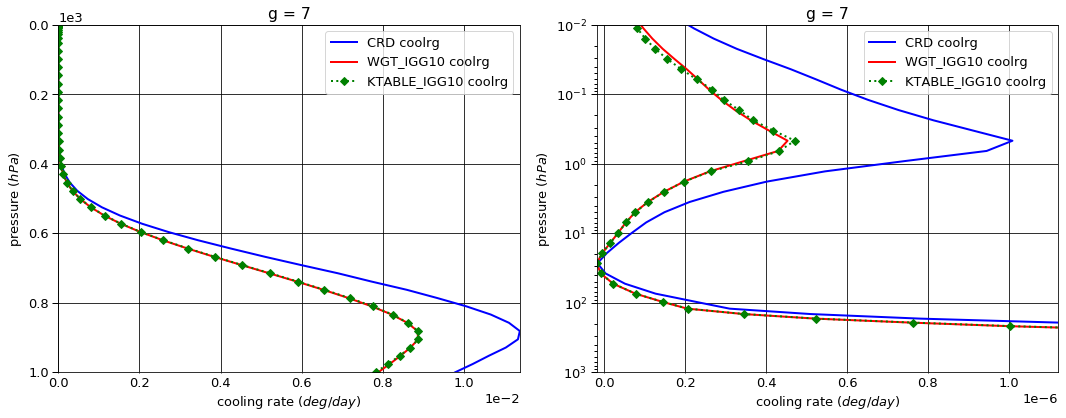

# Figure: cooling rate g-group total

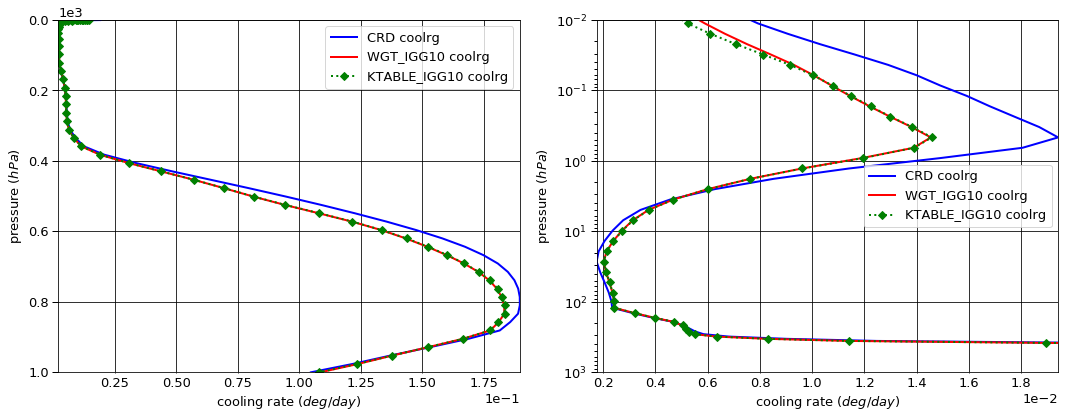

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.092919  0.000000 -0.092919
  1013.0   76    -0.160204  0.160311  0.000108
2 0.0      1     -0.454958  0.000000 -0.454958
  1013.0   76    -0.676300  0.678007  0.001707
3 0.0      1     -0.988074  0.000000 -0.988074
  1013.0   76    -1.254869  1.262640  0.007771
4 0.0      1     -2.107202  0.000000 -2.107202
  1013.0   76    -2.360151  2.334352 -0.025799
5 0.0      1     -5.134774  0.000000 -5.134774
  1013.0   76    -5.318812  3.770275 -1.548536
6 0.0      1     -9.733383  0.000000 -9.733383
  1013.0   76    -9.823956  3.117218 -6.706738
7 0.0      1     -3.986688  0.000000 -3.986688
  1013.0   76    -3.996846  0.451292 -3.545554


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.089351  0.000000 -0.089351
  1013.0   76    -0.160204  0.160300  0.000096
2 0.0      1     -0.445393  0.000000 -0.445393
  1013.0   76    -0.676300  0.677561  0.001262
3 0.0      1     -0.996201  0.000000 -0.996201
  1013.0   76    -1.254869  1.262612  0.007743
4 0.0      1     -2.134800  0.000000 -2.134800
  1013.0   76    -2.360151  2.368215  0.008064
5 0.0      1     -5.185369  0.000000 -5.185369
  1013.0   76    -5.318812  3.578664 -1.740148
6 0.0      1     -9.757962  0.000000 -9.757962
  1013.0   76    -9.823956  2.676510 -7.147446
7 0.0      1     -3.989314  0.000000 -3.989314
  1013.0   76    -3.996846  0.348651 -3.648195


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.089337  0.000000 -0.089337
  1013.0   76    -0.160204  0.160300  0.000096
2 0.0      1     -0.445274  0.000000 -0.445274
  1013.0   76    -0.676300  0.677568  0.001269
3 0.0      1     -0.995916  0.000000 -0.995916
  1013.0   76    -1.254869  1.262642  0.007773
4 0.0      1     -2.134282  0.000000 -2.134282
  1013.0   76    -2.360151  2.368362  0.008211
5 0.0      1     -5.184672  0.000000 -5.184672
  1013.0   76    -5.318812  3.582881 -1.735931
6 0.0      1     -9.757511  0.000000 -9.757511
  1013.0   76    -9.823956  2.681319 -7.142637
7 0.0      1     -3.989253  0.000000 -3.989253
  1013.0   76    -3.996846  0.349152 -3.647694


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.568013e-03  0.000000  0.003568
  1013.0   76     0.000000e+00 -0.000012 -0.000012
2 0.0      1      9.565300e-03  0.000000  0.009565
  1013.0   76     0.000000e+00 -0.000445 -0.000445
3 0.0      1     -8.126970e-03  0.000000 -0.008127
  1013.0   76     0.000000e+00 -0.000028 -0.000028
4 0.0      1     -2.759850e-02  0.000000 -0.027599
  1013.0   76    -4.440892e-16  0.033863  0.033863
5 0.0      1     -5.059480e-02  0.000000 -0.050595
  1013.0   76     0.000000e+00 -0.191612 -0.191612
6 0.0      1     -2.457950e-02  0.000000 -0.024579
  1013.0   76    -1.776357e-15 -0.440708 -0.440708
7 0.0      1     -2.625900e-03  0.000000 -0.002626
  1013.0   76     4.440892e-16 -0.102641 -0.102641


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.581702e-03  0.000000  0.003582
  1013.0   76     0.000000e+00 -0.000011 -0.000011
2 0.0      1      9.683850e-03  0.000000  0.009684
  1013.0   76     0.000000e+00 -0.000438 -0.000438
3 0.0      1     -7.841720e-03  0.000000 -0.007842
  1013.0   76     0.000000e+00  0.000002  0.000001
4 0.0      1     -2.708020e-02  0.000000 -0.027080
  1013.0   76    -4.440892e-16  0.034009  0.034009
5 0.0      1     -4.989770e-02  0.000000 -0.049898
  1013.0   76     0.000000e+00 -0.187394 -0.187394
6 0.0      1     -2.412820e-02  0.000000 -0.024128
  1013.0   76    -1.776357e-15 -0.435899 -0.435899
7 0.0      1     -2.565100e-03  0.000000 -0.002565
  1013.0   76     4.440892e-16 -0.102140 -0.102140

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.045584e-03
  1001.112500 75    -2.639566e-05
2 0.000312    1      7.301375e-04
  1001.112500 75    -4.434489e-04
3 0.000312    1      9.660354e-06
  1001.112500 75    -1.428378e-03
4 0.000312    1      1.389667e-06
  1001.112500 75     2.024261e-03
5 0.000312    1      1.334622e-06
  1001.112500 75     3.869727e-02
6 0.000312    1     -4.394984e-09
  1001.112500 75     5.607835e-02
7 0.000312    1     -6.310284e-09
  1001.112500 75     9.779806e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.201587e-03
  1001.112500 75    -2.650239e-05
2 0.000312    1      5.063556e-04
  1001.112500 75    -3.485173e-04
3 0.000312    1      3.682980e-06
  1001.112500 75    -1.560630e-03
4 0.000312    1      2.362063e-07
  1001.112500 75     1.043783e-03
5 0.000312    1      2.401630e-09
  1001.112500 75     4.743367e-02
6 0.000312    1     -3.523192e-08
  1001.112500 75     5.410543e-02
7 0.000312    1     -6.682536e-09
  1001.112500 75     7.882896e-03


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.027704e-03
  1001.112500 75    -2.656991e-05
2 0.000312    1      4.397851e-04
  1001.112500 75    -3.501168e-04
3 0.000312    1      1.157140e-06
  1001.112500 75    -1.562171e-03
4 0.000312    1      1.536563e-07
  1001.112500 75     1.025296e-03
5 0.000312    1      3.050071e-09
  1001.112500 75     4.724549e-02
6 0.000312    1     -2.243123e-08
  1001.112500 75     5.385218e-02
7 0.000312    1     -5.805941e-09
  1001.112500 75     7.818904e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.560032e-04
  1001.112500 75    -1.067320e-07
2 0.000312    1     -2.237819e-04
  1001.112500 75     9.493160e-05
3 0.000312    1     -5.977374e-06
  1001.112500 75    -1.322521e-04
4 0.000312    1     -1.153461e-06
  1001.112500 75    -9.804774e-04
5 0.000312    1     -1.332220e-06
  1001.112500 75     8.736394e-03
6 0.000312    1     -3.083693e-08
  1001.112500 75    -1.972922e-03
7 0.000312    1     -3.722527e-10
  1001.112500 75    -1.896910e-03


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.787960e-05
  1001.112500 75    -1.742470e-07
2 0.000312    1     -2.903523e-04
  1001.112500 75     9.333205e-05
3 0.000312    1     -8.503214e-06
  1001.112500 75    -1.337933e-04
4 0.000312    1     -1.236011e-06
  1001.112500 75    -9.989650e-04
5 0.000312    1     -1.331572e-06
  1001.112500 75     8.548220e-03
6 0.000312    1     -1.803624e-08
  1001.112500 75    -2.226173e-03
7 0.000312    1      5.043424e-10
  1001.112500 75    -1.960902e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.497997,0.000000,-22.497997
1013.0,76,-23.591138,11.774097,-11.817041



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.598390,0.000000,-22.598390
1013.0,76,-23.591138,11.072514,-12.518624



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.596245,0.000000,-22.596245
1013.0,76,-23.591138,11.082225,-12.508913



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.003924e-01,0.000000,-0.100392
1013.0,76,-3.552714e-15,-0.701583,-0.701583



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-9.824737e-02,0.000000,-0.098247
1013.0,76,-3.552714e-15,-0.691872,-0.691872


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.001788
1001.112500,75,0.104681



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001712
1001.112500,75,0.108530



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001469
1001.112500,75,0.108003



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000076
1001.112500,75,0.003849



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000319
1001.112500,75,0.003322


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.006750,0.006798
2,0.028563,0.028687
3,0.053000,0.053233
4,0.099562,0.100153
5,0.224750,0.225604
6,0.416125,0.416491
7,0.171250,0.169035


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.643251e-21
2,1.773812e-21
3,4.116584e-22
4,9.553585e-23
5,2.217154e-23
6,5.145472e-24
7,1.194138e-24


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.643251e-21,NaN,0.006750,0.006798,0.006750,0.006798,600.0
2,1.773812e-21,0.232076,0.028563,0.028687,0.035313,0.035485,600.0
3,4.116584e-22,0.232076,0.053000,0.053233,0.088313,0.088718,600.0
4,9.553585e-23,0.232076,0.099562,0.100153,0.187875,0.188871,600.0
5,2.217154e-23,0.232076,0.224750,0.225604,0.412625,0.414475,600.0
6,5.145472e-24,0.232076,0.416125,0.416491,0.828750,0.830965,600.0
7,1.194138e-24,0.232076,0.171250,0.169035,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.140106e-20  5.443034e-22  20.946155  6.935554e-07
      2 0.000312     1.706029e-21  3.551855e-23  48.032064  1.026086e-07
      3 0.000312     1.370940e-23  1.331799e-24  10.293890  8.512809e-10
      4 0.000312     1.483487e-24  1.997350e-25   7.427276  7.167256e-11
      5 0.000312     2.148874e-24  1.250037e-25  17.190487  9.682302e-11
      6 0.000312     1.651998e-25  1.682592e-26   9.818175  7.750759e-12
      7 0.000312     3.556451e-26  4.255555e-27   8.357196  1.695561e-12
2     1 0.000750     1.171315e-20  5.469618e-22  21.414930  2.868757e-07
      2 0.000750     1.750213e-21  3.560839e-23  49.151707  4.239122e-08
      3 0.000750     1.455673e-23  1.349308e-24  10.788298  3.634103e-10
      4 0.000750     1.546642e-24  2.033031e-25   7.607566  3.001311e-11
      5 0.000750     2.206738e-24  1.267601e-25  17.408778  4.002157e-11
      6 0.000750     1.720753e-25  1.723165e-26   9.986002  3.246782e-12
      7 0.000750     3.635016e-26  4.345531e-27   8.364953  6.979673e-13
3     1 0.001052     1.236296e-20  5.519739e-22  22.397730  4.242640e-07
      2 0.001052     1.842335e-21  3.576478e-23  51.512546  6.255312e-08
      3 0.001052     1.641001e-23  1.382762e-24  11.867559  5.725296e-10
      4 0.001052     1.680669e-24  2.105120e-25   7.983722  4.548698e-11
      5 0.001052     2.328757e-24  1.303857e-25  17.860533  5.914770e-11
      6 0.001052     1.869012e-25  1.804144e-26  10.359552  4.929314e-12
      7 0.001052     3.800614e-26  4.540779e-27   8.369961  1.023345e-12
4     1 0.001476     1.304846e-20  5.569704e-22  23.427575  6.276806e-07
      2 0.001476     1.939600e-21  3.593065e-23  53.981775  9.235339e-08
      3 0.001476     1.850008e-23  1.417809e-24  13.048356  9.026409e-10
      4 0.001476     1.826190e-24  2.181106e-25   8.372770  6.897997e-11
      5 0.001476     2.459788e-24  1.342333e-25  18.324723  8.752897e-11
      6 0.001476     2.033266e-25  1.885927e-26  10.781252  7.497124e-12
      7 0.001476     3.979720e-26  4.763072e-27   8.355364  1.503579e-12
5     1 0.002070     1.376227e-20  5.619392e-22  24.490680  9.278130e-07
      2 0.002070     2.041003e-21  3.610973e-23  56.522247  1.362575e-07
      3 0.002070     2.082584e-23  1.454543e-24  14.317792  1.421175e-09
      4 0.002070     1.982149e-24  2.260596e-25   8.768257  1.045077e-10
      5 0.002070     2.598966e-24  1.382541e-25  18.798472  1.295442e-10
      6 0.002070     2.213343e-25  1.966850e-26  11.253238  1.140592e-11
      7 0.002070     4.172219e-26  5.011900e-27   8.324626  2.211780e-12
6     1 0.002904     1.450504e-20  5.669287e-22  25.585294  1.370711e-06
      2 0.002904     2.146680e-21  3.630835e-23  59.123577  2.009632e-07
      3 0.002904     2.340995e-23  1.493380e-24  15.675818  2.235255e-09
      4 0.002904     2.149163e-24  2.344201e-25   9.167997  1.582395e-10
      5 0.002904     2.747006e-24  1.424373e-25  19.285717  1.918222e-10
      6 0.002904     2.411084e-25  2.046359e-26  11.782309  1.736504e-11
      7 0.002904     4.380471e-26  5.287426e-27   8.284694  3.259091e-12
7     1 0.004074     1.527743e-20  5.719890e-22  26.709314  2.023782e-06
      2 0.004074     2.256770e-21  3.653437e-23  61.771139  2.962717e-07
      3 0.004074     2.627700e-23  1.534775e-24  17.121074  3.511666e-09
      4 0.004074     2.327907e-24  2.432708e-25   9.569200  2.394441e-10
      5 0.004074     2.904726e-24  1.467794e-25  19.789743  2.841752e-10
      6 0.004074     2.628590e-25  2.124263e-26  12.374126  2.645732e-11
      7 0.004074     4.607409e-26  5.587816e-27   8.245456  4.811079e-12
8     1 0.005714     1.608030e-20  5.771866e-22  27.859792  2.985953e-06
      2 0.005714     2.371437e-21  3.679821e-23  64.444350  4.365650e-07
      3 0.005714     2.945415e-23  1.579338e-24  18.649686  5.510265e-09
      4 0.005714     2.519161e-24  2.527178e-25   9.968275  3.620803e-10
      5 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
